# EE16A Homework 5

## Can you Hear the Shape of a Drum?

We have seen that the PageRank Problem is defined in the form $A \vec{v} = \lambda \vec{v}$, where the transition of users from web page to web page reaches a steady state: even though the matrix $A$ re-distributes users to some new sites, the number of users on each web page doesn't change. In general, this represents a class of problems that are important in disciplines that require modeling. 

In the PageRank problem, the state $\vec{v}$ tells you how many users there are on each site at a particular time, and $\lambda$ tells you the score for each page. When you use the ($A \vec{v} = \lambda \vec{v}$) format for vibrational modes of a string or a membrane, the state $\vec{v}$ tells you how much displacement there is at a particular location on the object, and $\lambda$ tells you how much energy there is in that particular vibrational mode described by $\vec{v}$. 

This notebook will help you construct the matrix $A$ given some geometry, and then you will write a small amount of code to solve the problem $A \vec{v} = \lambda \vec{v}$ for $\lambda$ and $\vec{v}$.

## Define Some Helper Functions

You will need to make edits to two functions below: **<code>construct_1D_FDE</code>** and **<code>construct_2DSquare_FDE</code>**. 

**<code>construct_1D_FDE(l, N)</code>**: This function should take in two variables (<code>l</code>, the length of a string; <code>N</code>, the number of points on the string to model, including the anchor points) and output a matrix, $A$, which describes the 3-point finite difference model of the vibration of the string. $A$ should be $(N-2) \times (N-2)$.

Reminder: the 3-point difference formula is $$\frac{d^2 u}{dx^2} \approx \frac{u(x+h)-2u(x)+u(x-h)}{h^2}$$

**<code>construct_2DSquare_FDE(l, N)</code>**: This function should take in two variables (<code>l</code>, the side-length of a square membrane; <code>N</code>, the number of points on one side of a membrane to model, including the anchor points) and output a matrix, $A$, which describes the 5-point finite difference model of the vibration of the membrane. $A$ should be $(N-2)^2 \times (N-2)^2$.

Reminder: the 5-point difference formula is $$ \nabla^2 u(x,y) = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \approx \frac{u(x+h,y) + u(x,y+h)-4u(x,y) + u(x,y-h)+ u(x-h,y)}{h^2}$$

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from scipy import ndimage as nd
from scipy import misc
from scipy import io
from matplotlib import path

In [3]:
def construct_1D_FDE(l, N):
    # l = length of a string
    # N = number of points on a string
    ######## STUDENT: write code to generate matrix, A
    h = (l/(N-1.0));
    A = eye(N-2)*-2.0 + np.diag(np.ones((N-3)),-1) + np.diag(np.ones((N-3)),1);
    A = A/h**2;
    ######## END STUDENT EDITS
    return A;

In [4]:
def construct_2DSquare_FDE(l,N):
    # l = sidelength of a square
    # N = number of points on a side
    ######## STUDENT: write code to generate matrix, A
    x = linspace(0,l,N)
    [xx,yy] = meshgrid(x,x);
    h = l/(N-1);
    totalNumberOfPoints = (N-2)**2;
    diagonalSubs = eye(N-2)*-4.0 + np.diag(np.ones((N-3)),1) + np.diag(np.ones((N-3)),-1);
    offDiagonalSubs = eye(N-2);
    A = np.kron(eye(N-2),diagonalSubs);
    A = A + np.kron(np.diag(np.ones((N-3)),1)+np.diag(np.ones((N-3)),-1),offDiagonalSubs);
    A = -A/(h**2); # include negative sign so that vibration problem is consistent with that which is given in the homework.
    ######## END STUDENT EDITS
    
    ######## Do not edit the section below
    G = arange((N-2)*(N-2))+1;
    G = np.reshape(G,(N-2,N-2)).T;
    G = np.c_[zeros((N-2,1)),G,zeros((N-2,1))]
    G = np.r_[zeros((1,N)),G,zeros((1,N))]
    ######## Do not edit the section above

    return [A,G]

**The helper functions <code>numgrid</code> and <code>delsq</code> do not need to be edited.** They will be used to automatically generate the $A$ matrix for more arbitrary geometries than strings or squares. They are adapted from MATLAB developer Cleve Moler.

In [5]:
def delsq(G):
    # Do not edit.
    """
    DELSQ  Construct five-point finite difference Laplacian.
    delsq(G) is the sparse form of the two-dimensional,
    5-point discrete negative Laplacian on the grid G.
    adapted from  C. Moler, 7-16-91.
    Copyright (c) 1984-94 by The MathWorks, Inc.
    """
    [m,n] = G.shape
    # Indices of interior points
    G1 = G.flatten()
    p = np.where(G1)[0]
    N = len(p)
    # Connect interior points to themselves with 4's.
    i = G1[p]-1
    j = G1[p]-1
    s = 4*np.ones(p.shape)

    # for k = north, east, south, west
    for k in [-1, m, 1, -m]:
       # Possible neighbors in k-th direction
       Q = G1[p+k]
       # Index of points with interior neighbors
       q = np.where(Q)[0]
       # Connect interior points to neighbors with -1's.
       i = np.concatenate([i, G1[p[q]]-1])
       j = np.concatenate([j,Q[q]-1])
       s = np.concatenate([s,-np.ones(q.shape)])
    # sparse matrix with 5 diagonals
    A = zeros((N,N));
    for ind in range(0,i.shape[0]-1):
        A[i[ind],j[ind]] = s[ind];
    return A

**The helper functions <code>plotDrumMode</code> and <code>points_in_drum</code> do not need to be edited.** They will be used to visualize the vibrational modes of a membrane once you've solved the eigenvalue problem.

In [6]:
def plotDrumMode(V,modeNum,G,xx,yy):
    # Do not edit.
    numberOfPoints_x = xx.shape[0];
    numberOfPoints_y = yy.shape[0];
    V_n = V[:,modeNum];
    a_n = zeros_like(xx);
    for i in range(0,numberOfPoints_x-1):
        for j in range(0,numberOfPoints_y-1):
            V_ind = G[i,j]-1;
            if (V_ind >= 0)&(V_ind < V_n.shape[0]):
                a_n[i,j] = V_n[int(V_ind)]
            else:
                a_n[i,j] = 0;
    plt.figure(figsize=(2,2))
    CS = plt.contour(xx, yy, a_n)
    return [CS]

In [7]:
def points_in_drum(xx,yy,drumPath):
    # Do not edit.
    h = xx[0,1]-xx[0,0];
    positions = np.vstack([xx.ravel(), yy.ravel()])
    positionBooleanIn = drumPath.contains_points(positions.T,transform=None,radius=-0.000000000000001)
    positionBooleanOnIn = drumPath.contains_points(positions.T,transform=None,radius=0.000000000000001)
    pointsInPolygon = positions.T[positionBooleanIn]/h;
    pointsOnPolygon = positions.T[positionBooleanOnIn^positionBooleanIn]/h;
    G = np.zeros(xx.shape,dtype=np.int)
    for i in range(pointsInPolygon.shape[0]):
        G[int(pointsInPolygon[i,0]),int(pointsInPolygon[i,1])] = i+1;
        
    return [pointsInPolygon,pointsOnPolygon,G]

In [8]:
def construct_2DPolygon_FDE(gridDensity,gridLength,drum_path):
    # Do not edit.
    N = gridDensity*gridLength;
    h = 1.0/gridDensity;
    x = linspace(0,gridLength,N+1);
    xx,yy = meshgrid(x,x);
    [pointsInPolygon,pointsOnPolygon,G] = points_in_drum(xx,yy,drum_path);
    A_drum = delsq(G)/(h**2)
    return [A_drum,G]

## Parts a) - d)
Use the <code>construct_1D_FDE</code> helper function to generate the matrix $A$ for a string length of 1 and 50 model points. Then use an eigenvalue solver to find the eigenvalues and eigenvectors for $A$. (You can use functions built into the <code>linalg</code> library to do this. I suggest the <code>eigh</code> function.)

In [9]:
stringLength = 1.0; # play with this value
numberOfPoints = 50; # play with this value
h = stringLength/(numberOfPoints-1);
x = arange(numberOfPoints)*h;

A = construct_1D_FDE(stringLength,numberOfPoints);
# hint: if you implemented this code correctly, when stringLength=1.0 and numberOfPoints=5,
# you should get the 3x3 matrix that part a) asks for.

In [10]:
# Solution to the eigenvalue problem:
##### Student utilize solver here.
[evals,evecs] = linalg.eigh(A);
# evecs = matrix whose columns are the eigenvectors of A
# evals = vector whose columns are the eigenvalues of A corresponding to the columns of evecs

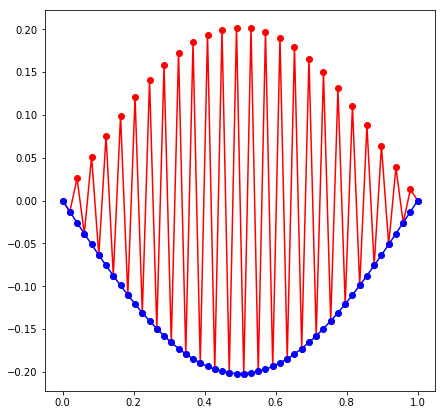

In [11]:
# Plot the first and last eigenvectors
first_evec = evecs[:,0]
last_evec = evecs[:,-1]
first_eval = evals[0]
last_eval = evals[-1]

x = arange(numberOfPoints)*h;

plt.figure(figsize=(7,7))
plt.plot(x,np.r_[0,first_evec,0],'r-o');
plt.plot(x,np.r_[0,last_evec,0],'b-o');

## Part g)
Use the <code>construct_2DSquare_FDE</code> helper function to generate the matrix $A$ for a square membrane with side-length of 1 and 50 points along a side. Then use an eigenvalue solver to find the eigenvalues and eigenvectors for $A$. (Use the same eigenvalue solver you used above.) There is a little extra code to generate a matrix, G, which will be used to plot the results. You don't need to modify this code to get your solution working. 

In [12]:
# First, for 5x5 drum
sidelength = 1.0; # play with this value
numberOfPoints = 5; # play with this value

x = linspace(0,sidelength,numberOfPoints) # Do not edit
[xx,yy] = meshgrid(x,x); # Do not edit

[A_squareDrum,G] = construct_2DSquare_FDE(sidelength,numberOfPoints); # calls the helper function you defined above.

######## Student: implement eigen-solution here to find eigen values of A_squareDrum
[D,V] = linalg.eigh(A_squareDrum);


In [13]:
# The eigenvalues of the 5x5 drum
# There are 9 eigenvalues, with some degeneracy (some eig-vals are the same)
print(D)

[ 18.745166  41.372583  41.372583  64.        64.        64.
  86.627417  86.627417 109.254834]


In [14]:
# Next, we'll plot for 50x50 drum
sidelength = 1.0; # play with this value
numberOfPoints = 50; # play with this value

x = linspace(0,sidelength,numberOfPoints) # Do not edit
[xx,yy] = meshgrid(x,x); # Do not edit

[A_squareDrum,G] = construct_2DSquare_FDE(sidelength,numberOfPoints); # calls the helper function you defined above.

######## Student: implement eigen-solution here to find eigen values of A_squareDrum
[D,V] = linalg.eigh(A_squareDrum);

The <code>plotDrumMode</code> function takes your eigenvectors (formatted as column vectors; if you use <code>[D,V] = linalg.eigh(A_squareDrum)</code>, you can pass <code>V</code>), a number corresponding to the mode you want to plot, and the variables defined in the "do not edit" section (<code>G</code>, <code>xx</code>, and <code>yy</code>). Plot the zero-th and first modes.


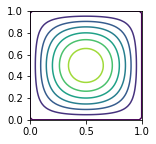

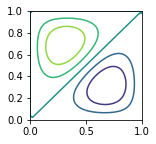

In [15]:
plotDrumMode(V,0,G,xx,yy)
plotDrumMode(V,1,G,xx,yy)

## Parts h) - i)
Here are two polygon shapes that we will study, <code>drum1</code> and <code>drum1</code>. The variables <code>gridDensity</code> and <code>gridLength</code> describe the density of model points and the side-length of the square model grid. You can modify these values to get higher spatial resolution results, but remember that this trades off with the amount of memory and time the code needs to run!

In [16]:
drum1_path = path.Path([(0,0), (1,0), (3,2), (2,2),
              (2,3),(1,2),(1,1),(0,1),(0,0)])
drum2_path = path.Path([(0,1), (1,0), (2,0), (2,2),
              (3,2),(2,3),(1,2),(1,1),(0,1)])

gridDensity = 32; # increase this to change the number of points in the model. More points = more time and memory, so be careful.
gridLength = 3;


[A_weirdDrum1,G1] = construct_2DPolygon_FDE(gridDensity,gridLength,drum1_path);
[A_weirdDrum2,G2] = construct_2DPolygon_FDE(gridDensity,gridLength,drum2_path);

[D1,V1] = linalg.eigh(A_weirdDrum1);
[D2,V2] = linalg.eigh(A_weirdDrum2);

In [17]:
V1.shape

(3441, 3441)

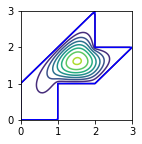

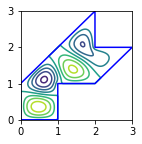

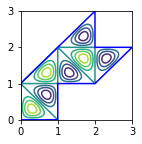

In [18]:
# defining drum1 and drum2 for easy plotting of the drum shape.
drum1 = np.array([[0, 0, 2, 2, 3, 2, 1, 1, 0],
                  [0, 1, 3, 2, 2, 1, 1, 0, 0]]);
drum2 = np.array([[1, 0, 0, 2, 2, 3, 2, 1, 1],
                  [0, 1, 2, 2, 3, 2, 1, 1, 0]]);
N = gridDensity*gridLength;
x = linspace(0,gridLength,N+1);
xx,yy = meshgrid(x,x);


# plot the drum mode
plotDrumMode(V1,0,G1,xx,yy)
# plot the outline of the drum
plt.plot(drum1[0,:],drum1[1,:],'b')

plotDrumMode(V1,4,G1,xx,yy)
plt.plot(drum1[0,:],drum1[1,:],'b')

plotDrumMode(V1,8,G1,xx,yy)
plt.plot(drum1[0,:],drum1[1,:],'b')

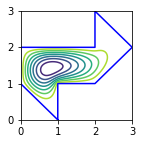

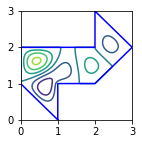

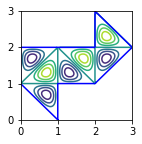

In [19]:
# plot the drum mode
# plot the drum mode
plotDrumMode(V2,0,G2,xx,yy)
# plot the outline of the drum
plt.plot(drum2[0,:],drum2[1,:],'b')

plotDrumMode(V2,4,G2,xx,yy)
plt.plot(drum2[0,:],drum2[1,:],'b')

plotDrumMode(V2,8,G2,xx,yy)
plt.plot(drum2[0,:],drum2[1,:],'b')

Compare the eigenvalues for the modes of the two drum shapes. These correspond to the drum pitches, or frequencies. Do the drums sound the same according to your simulation? Why or why not?

In [20]:
D1

array([  10.16587962,   14.63060087,   20.71763399, ..., 8171.28236601,
       8177.36939913, 8181.83412038])

In [21]:
D2

array([  10.16587962,   14.63060087,   20.71763402, ..., 8171.28236598,
       8177.36939913, 8181.83412038])